<a href="https://colab.research.google.com/github/ShrutiAggarwal99/udacity-deep-learning-with-pytorch/blob/master/L6_mnist_mlp_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np

In [2]:
train_data = datasets.MNIST(root='data',train=True,transform=transforms.ToTensor(),download=True)
test_data = datasets.MNIST(root='data',train=False,transform=transforms.ToTensor(),download=True)

# training indices to be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices) # shuffle the indices
valid_size = 0.2
split = int(np.floor(valid_size*num_train))
validation_indices, train_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(validation_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=validation_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

0it [00:00, ?it/s]

9920512it [00:01, 9004823.86it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 121607.05it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2001908.60it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 46590.17it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

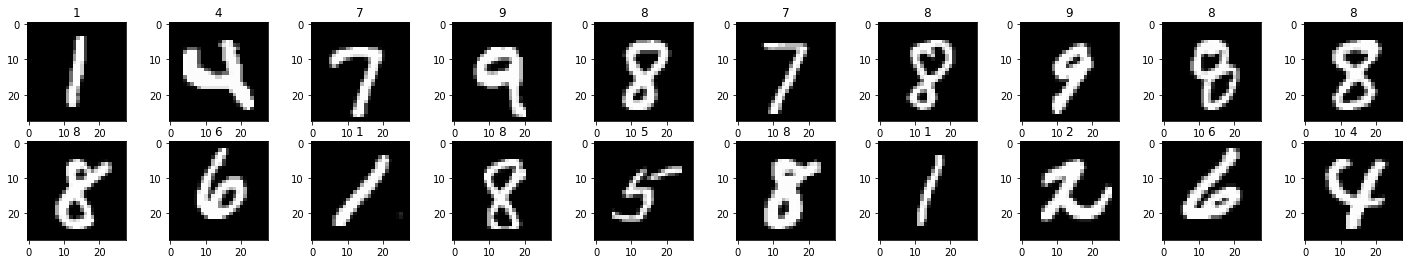

In [6]:
# Visualising my data

images, labels = next(iter(train_loader))

images, labels = images.numpy(), labels.numpy()

fig = plt.figure(figsize=(25,4))
for idx in range(20):
  ax = fig.add_subplot(2,10,idx+1)
  ax.imshow(images[idx].squeeze(), cmap='gray')
  ax.set_title(labels[idx])

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [19]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,512)
    self.fc2 = nn.Linear(512,512)
    self.fc3 = nn.Linear(512,10)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.log_softmax(self.fc3(x),dim=1)

    return x

# Initialise the NN
classifier = Network()
print(classifier)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier.to(device)

print(next(classifier.parameters()).is_cuda)

True


In [21]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(classifier.parameters(),lr = 0.01)

epochs = 75

min_valid_loss = np.Infinity

for e in range(epochs):
  train_loss = 0
  # training
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    log_ps = classifier(images)
    loss = criterion(log_ps,labels)
    train_loss += loss.item()*images.shape[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # validation
  valid_accuracy = 0
  valid_loss = 0
  with torch.no_grad():
    classifier.eval()
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)

      log_ps = classifier(images)
      valid_loss += criterion(log_ps,labels).item()*images.shape[0]

      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(k=1,dim=1)
      equals = top_class == labels.view(*top_class.shape)
      valid_accuracy += torch.mean(equals.type(torch.FloatTensor))*images.shape[0]
    classifier.train()

  print("Epoch: ", e+1,
      "Training Loss:", train_loss/len(train_loader.sampler),
      "Validation Loss:", valid_loss/len(validation_loader.sampler),
      "Accuracy:", valid_accuracy/len(validation_loader.sampler))
     
  if valid_loss < min_valid_loss:
    torch.save({'state_dict': classifier.state_dict()}, 'checkpoint.pth.tar')
    min_valid_loss = valid_loss
    print("Validation Loss decreased, model saved!")

Epoch:  1 Training Loss: 1.8030532162189483 Validation Loss: 0.9057743317286173 Accuracy: tensor(0.7963)
Validation Loss decreased, model saved!
Epoch:  2 Training Loss: 0.6635736306508382 Validation Loss: 0.4688120195070902 Accuracy: tensor(0.8757)
Validation Loss decreased, model saved!
Epoch:  3 Training Loss: 0.45907430720329284 Validation Loss: 0.37965463105837505 Accuracy: tensor(0.8939)
Validation Loss decreased, model saved!
Epoch:  4 Training Loss: 0.3923823727965355 Validation Loss: 0.33949967082341515 Accuracy: tensor(0.9038)
Validation Loss decreased, model saved!
Epoch:  5 Training Loss: 0.35492633636792503 Validation Loss: 0.3119100158214569 Accuracy: tensor(0.9098)
Validation Loss decreased, model saved!
Epoch:  6 Training Loss: 0.32614752393960955 Validation Loss: 0.2913393006324768 Accuracy: tensor(0.9180)
Validation Loss decreased, model saved!
Epoch:  7 Training Loss: 0.303172276198864 Validation Loss: 0.27169174774487814 Accuracy: tensor(0.9227)
Validation Loss decr

In [22]:
checkpoint = torch.load('checkpoint.pth.tar')
classifier.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [27]:
# test he model (saved with least validation loss)

test_loss = 0
accuracy = 0
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  log_ps = classifier(images)
  loss = criterion(log_ps, labels)
  test_loss += loss.item()*images.shape[0]
  ps = torch.exp(log_ps)
  top_p, top_class = ps.topk(k=1,dim=1)
  equality = top_class == labels.view(*top_class.shape)
  accuracy += torch.mean(equality.type(torch.FloatTensor))*images.shape[0]

print("Test Loss: ", test_loss/len(test_loader.dataset),
        "Test Accuracy: ", accuracy/len(test_loader.dataset))

Test Loss:  0.07839999163150788 Test Accuracy:  tensor(0.9754)


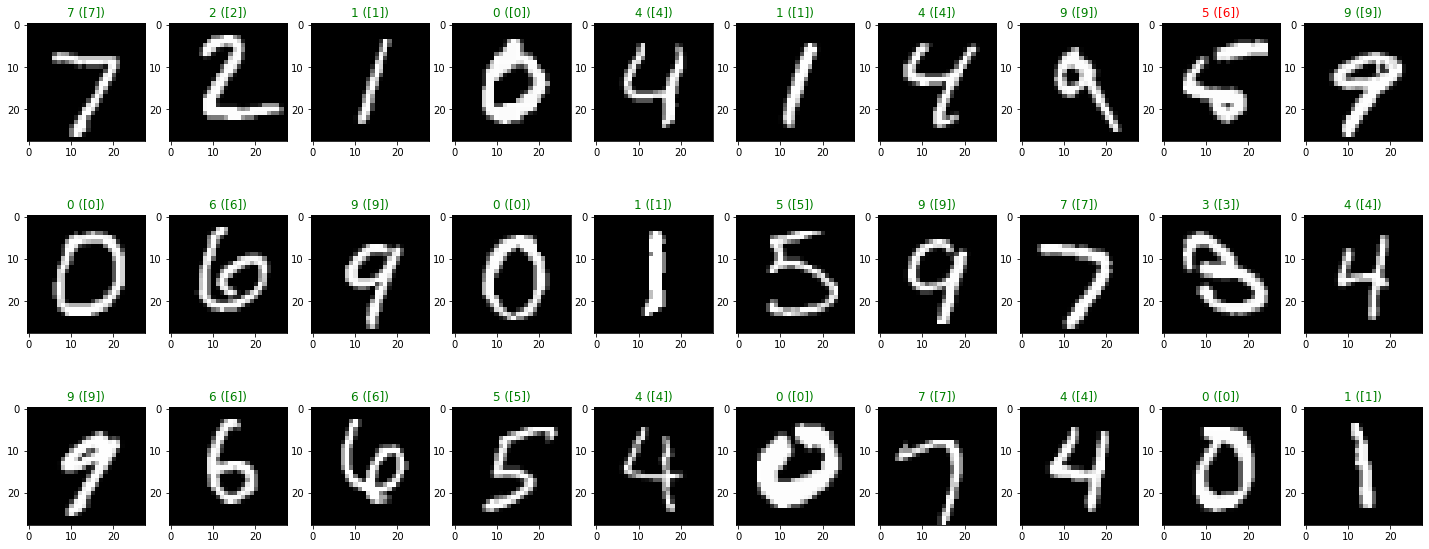

In [49]:
# Visualise the results on test data

images, labels = next(iter(test_loader))

images, labels = images.to(device), labels.to(device)

log_ps = classifier(images)
ps = torch.exp(log_ps)

top_p, top_class = ps.topk(k=1, dim=1)

images, labels = images.to('cpu').numpy(), labels.to('cpu').numpy()
top_class = top_class.to('cpu').numpy()

fig = plt.figure(figsize=(25,10))
for i in range(30):
  ax = fig.add_subplot(3,10,i+1)
  ax.imshow(images[i].squeeze(), cmap='gray')
  ax.set_title("{} ({})".format(str(labels[i]), str(top_class[i])),color=("green" if top_class[i]==labels[i] else "red"))